# Simple Image Classification with Neural Networks

## Introduction

This quest will challenge you to build a simple image classifier using neural network building blocks you already know, as well as some new techniques.

## The "Fashion MNIST" Data Set

Load the "Fashion MNIST" data set from Keras:

In [1]:
# All the imports
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn_image as isns

from numpy.random import default_rng
from sklearn.metrics import classification_report

In [2]:
# This loads train and test data from the "Fashion MNIST" dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [3]:
# We got 60k images in X_train and their labels in y_train
print(f"X_train shape = {X_train.shape}")
print(f"y_train shape = {y_train.shape}")

# Divider
print(f"-------------------------------")

# We got 10k images and labels in X_test and y_test sets
print(f"X_test shape = {X_test.shape}")
print(f"y_test shape = {y_test.shape}")

X_train shape = (60000, 28, 28)
y_train shape = (60000,)
-------------------------------
X_test shape = (10000, 28, 28)
y_test shape = (10000,)


We have 10 classes of items to distinguish, encoded as integer labels:

In [4]:
# Class names
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

# Making a mapping dictionary from integers to names
class_label = dict(zip(range(10), class_names))

## Exercise

Display 10 random images from the Fashion MNIST data set and annotate the image with the class label.

In [29]:
# Function that plots N random images from given dataset, label array
def show_random_fashion(X,y,n=10,size=3):
    
    # Initialize figure size
    figsize = (n*(size+1), size)

    # I am using numpy.random.default_rng (random numbers generator)
    rng = default_rng()

    # It offers option to replace=False, i.e. takes N samples without repeating from a set
    index = rng.choice(range(0,X.shape[0]), size=n, replace=False)
    
    # Make N subplots
    fig, axs = plt.subplots(nrows=1, ncols=n, figsize=figsize)

    # Intiate loop counter
    loop = -1

    # Let's loop over random 10 numbers from the generator:
    for i in index:

        # Count the loop
        loop += 1

        # Plot the image with the data index = i 
        isns.imgplot(X[i],ax=axs[loop], cmap="gist_yarg", showticks=True)

        # Add the title from the label translated via class_label dictionary
        axs[loop].set_title(f"{i}: {class_label[y[i]]}")

        # Inverse Y axis, so the images are well orientated
        axs[loop].invert_yaxis()

    plt.show()

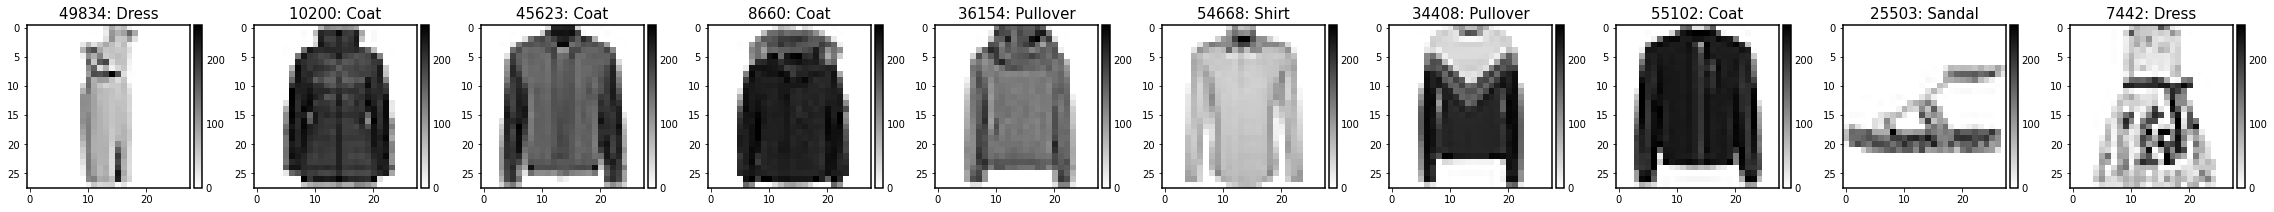

In [30]:
show_random_fashion(X_train, y_train, 10)

# Challenge 1: Build a Fashion MNIST Classifier

Build, train and evaluate a neural network that is able to classify these images with high accuracy.

Start your model architecture from the following code snippet:

```python
net = keras.models.Sequential([
    keras.layers.Flatten(),
    # add layers here
])
```

## Data pre-processing

Inspecting the dataset balance:

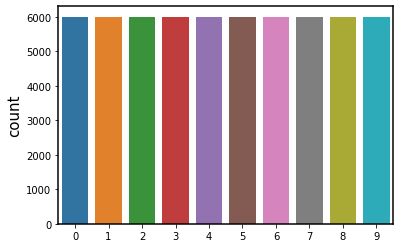

In [7]:
# Perfectly balanced set:
sns.countplot(x=y_train)
plt.show()

We need to encode the data first, so we need to do two things:
  - normalize the data to range $<0, 1>$
  - one-hot encode the classes

In [8]:
# Let's setup two functions to do the tasks:

# Function to normalize the data to range <0,1>
def normalize_image(data):

    # Normalizing from <0,255> to <0,1>
    return data / 255


# Function to one-hot encode the data
def one_hot_encode(data):
    n_classes = 10

    # np.eye -> Returns a 2-D array with ones on the diagonal and zeros elsewhere.
    # 
    # When you call a data as index -> it returns a row from "eye" matrix
    # corresponding to the class numer (in data)
    encoded_data = np.eye(n_classes)[data]

    return encoded_data

Following code makes a test - displays random images after they're normalized. It is apparent the new Y axis range is $<0,1>$.

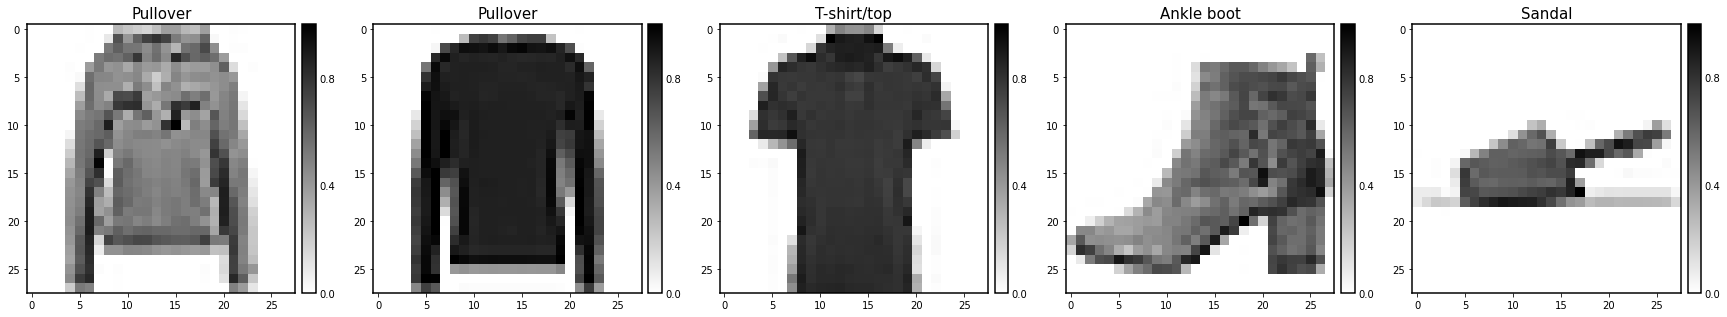

In [9]:
show_random_fashion(normalize_image(X_train), y_train, 5, 5)

Following cell tests the result of `one_hot_encode(data)` function. It takes a sample of 10 labels from `y_test` and prints them one-hot encoded.

In [10]:
# Get a sample of 10 labels from y_test
rng = default_rng()
index = rng.choice(range(0,y_test.shape[0]), size=10, replace=False)

# Print them out and then again one-hot encoded:
[print(f"{y_test[i]} -> {one_hot_encode(y_test[i])}") for i in index]
print()

6 -> [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
0 -> [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1 -> [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
6 -> [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
2 -> [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
7 -> [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
9 -> [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
7 -> [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
2 -> [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
9 -> [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]



Now we prepare the datasets

In [11]:
X_train_ready = normalize_image(X_train)
y_train_ready = one_hot_encode(y_train)

X_test_ready = normalize_image(X_test)
y_test_ready = one_hot_encode(y_test)

## Neural Network Architecture

In [18]:
# Function to create new model
def setup_model(
        neurons,
        activation="relu",
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        output_activation="softmax",
        batch_normalize=False,
        dropout=0):

    # Create Sequential model
    model = tf.keras.models.Sequential()

    # Create input shape (28 x 28 image)
    model.add(tf.keras.Input(shape=(28, 28)))

    # Add Flatten layer to flatten 28 x 28 to 784 features
    model.add(tf.keras.layers.Flatten())

    # Initialize hidden layers into a list
    layers = []
    index = -1
    for n in neurons:
        index += 1
        layers.append(
            tf.keras.layers.Dense(
                units=n,
                activation=activation,
                kernel_initializer=kernel_initializer,
                use_bias=True
                )
            )
        if batch_normalize:
            layers.append(
                tf.keras.layers.BatchNormalization()
            )
            
        if dropout > 0:
            layers.append(
                tf.keras.layers.Dropout(rate=dropout)
            )

    # Add all hidden layers    
    [model.add(layer) for layer in layers]

    # Add last Dense layer for Output (10 nodes)
    model.add(
        tf.keras.layers.Dense(
            units=10,
            activation=output_activation,
            kernel_initializer=kernel_initializer,
            use_bias=True
            )
    )

    model.summary()

    return model

In [13]:
# Evaluate model on test data
def evaluate(model, X_test, y_test):
    scores = model.evaluate(X_test, y_test, verbose=1, batch_size=y_test.shape[0])


# This function will retrieve and plot all observed model performance metrics
def show_history(s, suptitle="", scale = "linear"):
    
    # Automatically retrieve list of all metrics from history
    metrics = list(s.history.keys())[:len(list(s.history.keys()))//2]

    # Calculate amount of metrics
    nrows = len(metrics)

    # Set figure size to 12 x N*5 (where N is number of metrics [nrows])
    fig, axs = plt.subplots(nrows=nrows, ncols=1, figsize=(12, 5 * nrows))

    fig.suptitle(suptitle)

    index = -1

    for metric in metrics:
        index+=1

        axs[index].plot(s.history[metric], label=metric)
        axs[index].plot(s.history["val_"+metric], label="val_"+metric)
        axs[index].set_yscale(scale)
        axs[index].legend()
        axs[index].grid(b=True, which="major", axis="y")
        axs[index].set_title("Observed "+metric)
    
    plt.show()
    plt.close()

# Function to show classification report
def show_classification_report(model, X_test, y_test):
    y_pred = model.predict(X_test)
    classification_report(y_test, y_pred, target_names=class_names)


In [14]:
# Default metrics
metrics=[tf.keras.metrics.CategoricalAccuracy()]

In [25]:
# Meta function to setup and train the model
def train_model(
    name,
    X,
    y,
    neurons,
    batch_size,
    epochs,
    validation_split=0.3,
    shuffle=True,
    activation="relu",
    kernel_initializer="glorot_uniform",
    bias_initializer="zeros",
    output_activation="softmax",
    batch_normalize=False,
    dropout=0,
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer="adam",
    metrics=[tf.keras.metrics.CategoricalAccuracy()],
    verbose=1
):

    model = setup_model(
        neurons=neurons,
        activation=activation,
        kernel_initializer=kernel_initializer,
        bias_initializer=bias_initializer,
        output_activation=output_activation,
        batch_normalize=batch_normalize,
        dropout=dropout)

    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    story = model.fit(
        x=X,
        y=y,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=0.3,
        shuffle=True,
        verbose=verbose
    )

    evaluate(model, X, y)

    show_history(story, name)

    return model, story


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 90)                70650     
_________________________________________________________________
dense_7 (Dense)              (None, 30)                2730      
_________________________________________________________________
dense_8 (Dense)              (None, 10)                310       
Total params: 73,690
Trainable params: 73,690
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 1s 894ms/step - loss: 0.2383 - categorical_accuracy: 0.9160


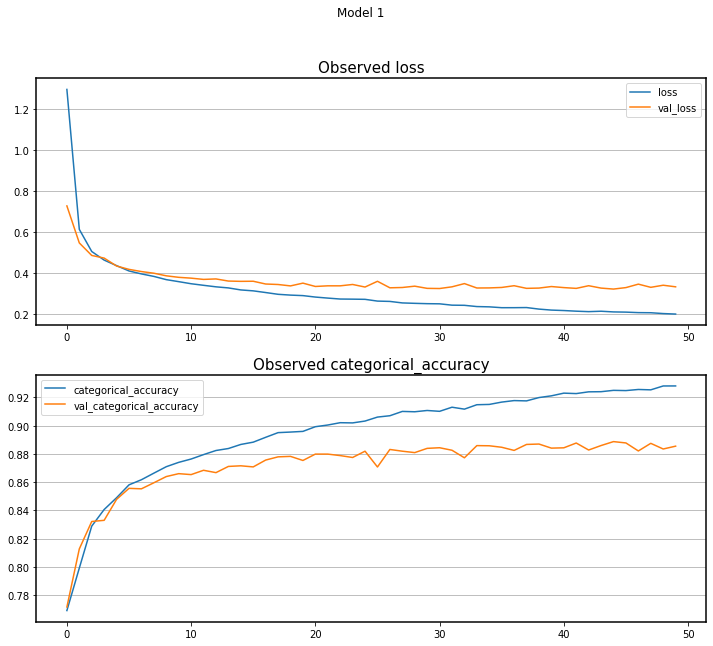

In [20]:
m1, s1 = train_model(
    "Model 1",
    X_train_ready,
    y_train_ready,
    neurons=[90,30],
    batch_size=1000,
    epochs=50,
    validation_split=0.3,
    shuffle=True,
    activation="relu",
    kernel_initializer="glorot_uniform",
    bias_initializer="zeros",
    output_activation="softmax",
    batch_normalize=False,
    dropout=0,
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer="adam",
    metrics=metrics
)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 90)                70650     
_________________________________________________________________
dropout_2 (Dropout)          (None, 90)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 30)                2730      
_________________________________________________________________
dropout_3 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)                310       
Total params: 73,690
Trainable params: 73,690
Non-trainable params: 0
__________________________________________________

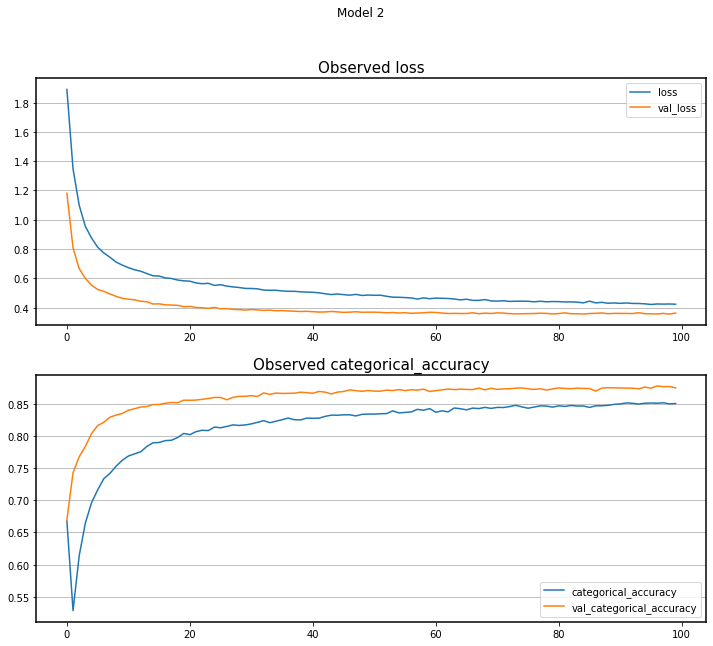

In [21]:
m2, s2 = train_model(
    "Model 2",
    X_train_ready,
    y_train_ready,
    neurons=[90,30],
    batch_size=1000,
    epochs=100,
    validation_split=0.3,
    shuffle=True,
    activation="relu",
    kernel_initializer="glorot_uniform",
    bias_initializer="zeros",
    output_activation="softmax",
    batch_normalize=False,
    dropout=0.5,
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer="adam",
    metrics=metrics
)

Next model utilizes _BatchNormalization_ layers.

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 90)                70650     
_________________________________________________________________
batch_normalization (BatchNo (None, 90)                360       
_________________________________________________________________
dropout_4 (Dropout)          (None, 90)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 30)                2730      
_________________________________________________________________
batch_normalization_1 (Batch (None, 30)                120       
_________________________________________________________________
dropout_5 (Dropout)          (None, 30)               

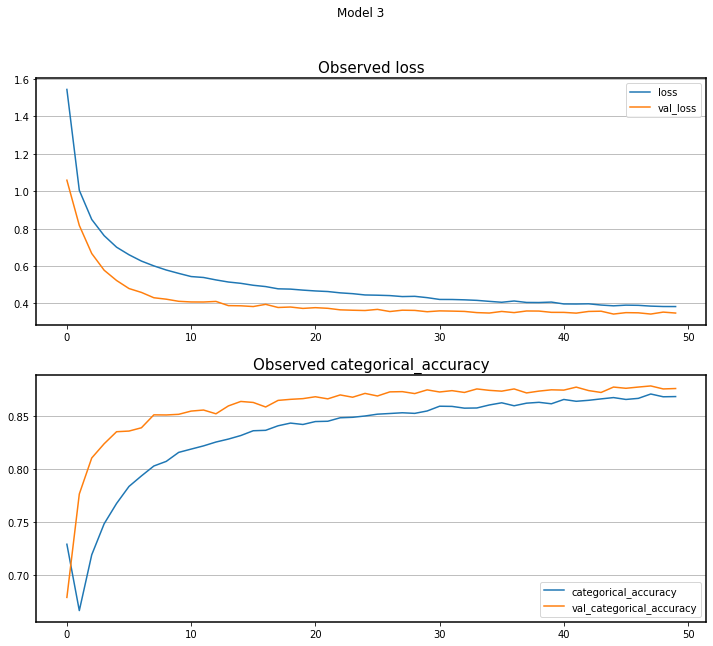

In [22]:
m3, s3 = train_model(
    "Model 3",
    X_train_ready,
    y_train_ready,
    neurons=[90,30],
    batch_size=1000,
    epochs=50,
    validation_split=0.3,
    shuffle=True,
    activation="relu",
    kernel_initializer="glorot_uniform",
    bias_initializer="zeros",
    output_activation="softmax",
    batch_normalize=True,
    dropout=0.5,
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer="adam",
    metrics=metrics
)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 8)                 6280      
_________________________________________________________________
batch_normalization_2 (Batch (None, 8)                 32        
_________________________________________________________________
dropout_6 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_16 (Dense)             (None, 4)                 36        
_________________________________________________________________
batch_normalization_3 (Batch (None, 4)                 16        
_________________________________________________________________
dropout_7 (Dropout)          (None, 4)                

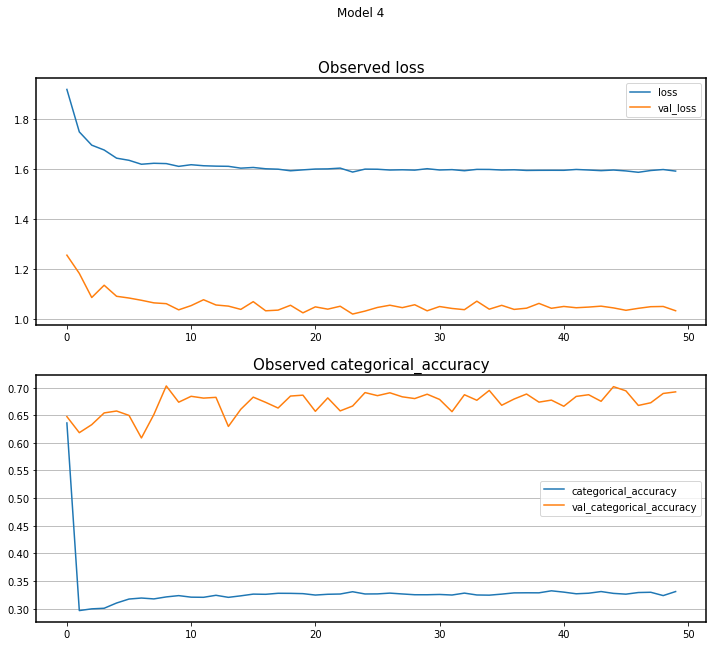

In [23]:
m4, s4 = train_model(
    "Model 4",
    X_train_ready,
    y_train_ready,
    neurons=[8,4],
    batch_size=32,
    epochs=50,
    validation_split=0.3,
    shuffle=True,
    activation="relu",
    kernel_initializer="glorot_uniform",
    bias_initializer="zeros",
    output_activation="softmax",
    batch_normalize=True,
    dropout=0.5,
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer="adam",
    metrics=metrics
)

## Summary

Here are the evaluations of all models:

In [26]:
[evaluate(model, X_test_ready, y_test_ready) for model in [m1, m2, m3, m4]]

1/1 [==============================] - 0s 322ms/step - loss: 1.0419 - categorical_accuracy: 0.6901


[None, None, None, None]

First three are over 80% for categorical accuracy.

I decided to check the random prediction of model `m3`.

Developed a function to print out random selection of images with their true and recognized labels.

In [46]:
# Function that plots N random images from given dataset, label array + prediction result
def show_fashion_recognitions(X,y,model,n=10,size=3):
    
    # Initialize figure size
    figsize = (n*(size+1), 2*size)

    # I am using numpy.random.default_rng (random numbers generator)
    rng = default_rng()

    # It offers option to replace=False, i.e. takes N samples without repeating from a set
    index = rng.choice(range(0,X.shape[0]), size=n, replace=False)
    
    # Make N subplots
    fig, axs = plt.subplots(nrows=2, ncols=n, figsize=figsize)

    # Intiate loop counter
    loop = -1

    # Let's loop over random 10 numbers from the generator:
    for i in index:

        # Count the loop
        loop += 1

        # Plot the image with the data index = i 
        isns.imgplot(X[i],ax=axs[0][loop], cmap="gist_yarg", showticks=True)

        # Add the title from the label translated via class_label dictionary
        axs[0][loop].set_title(f"True {i}: {class_label[y[i]]}")

        # Inverse Y axis, so the images are well orientated
        axs[0][loop].invert_yaxis()

    # Reset loop
    loop = -1

    # Let's loop over random 10 numbers from the generator:
    for i in index:

        # Count the loop
        loop += 1

        # Plot the image with the data index = i 
        isns.imgplot(X[i],ax=axs[1][loop], cmap="gist_yarg", showticks=True)

        # Add the title from the label translated via class_label dictionary
        axs[1][loop].set_title(f"Recognition {i}: {class_names[np.argmax(model.predict(X)[i])]}")

        # Inverse Y axis, so the images are well orientated
        axs[1][loop].invert_yaxis()


    plt.show()

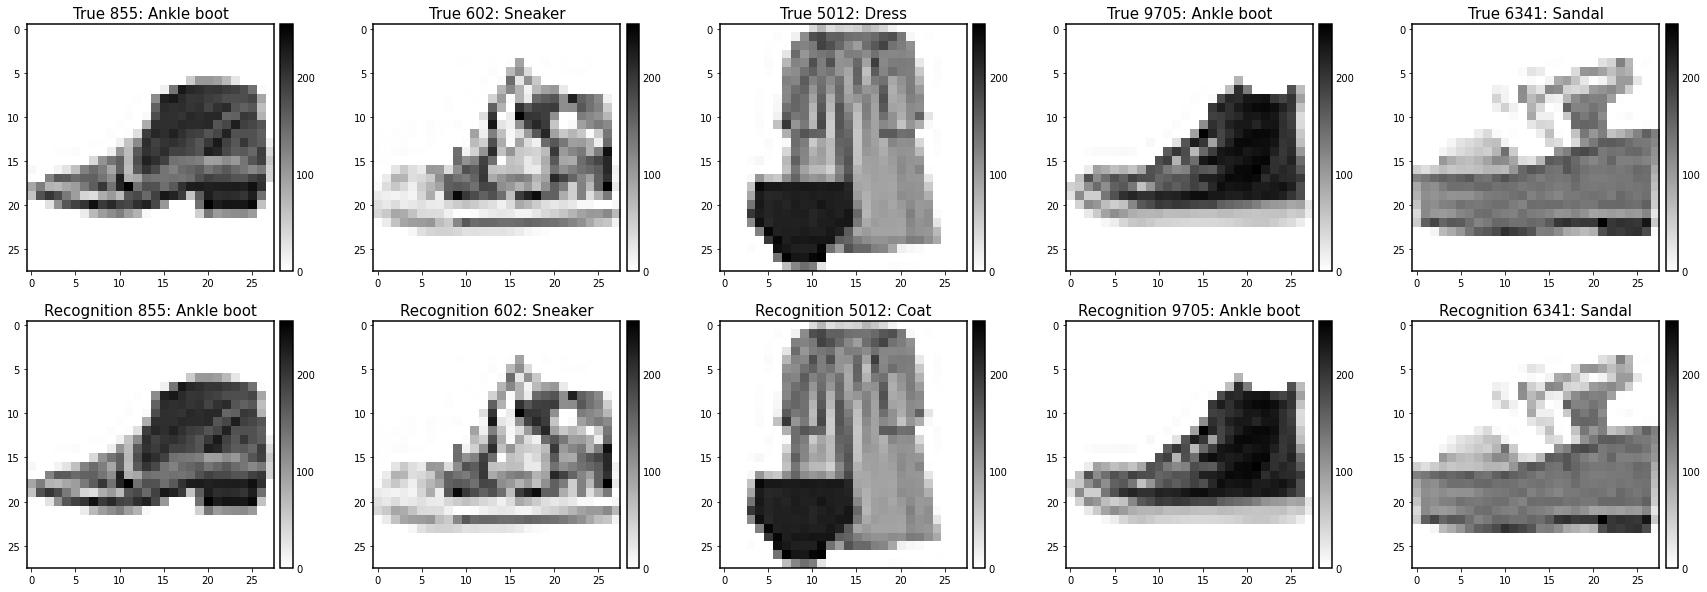

In [47]:
show_fashion_recognitions(X_test, y_test, model=m3, n=5, size=5)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=87989bd7-7a25-4e61-b3c0-cb24ea7ca1f8' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>